# <center>TMVA di-Higgs Classification Example in Python</center>

In this example we will still do Higgs classification but we will use together with the native TMVA methods also methods from Keras and scikit-learn, and then we will compare them.

In [1]:
import ROOT
from ROOT import TMVA

Welcome to JupyROOT 6.14/04


## Declare Factory and Input Data

In [2]:
ROOT.TMVA.Tools.Instance()
## For PYMVA methods
TMVA.PyMethodBase.PyInitialize();


outputFile = ROOT.TFile.Open("Higgs_ClassificationOutput.root", "RECREATE")

# Factory
factory = ROOT.TMVA.Factory("TMVA_Higgs_Classification", outputFile,
                      "!V:ROC:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

# Input data
# We define now the input data file and we retrieve the ROOT TTree objects with the signal and background input events
inputFileNameS = "RSG_C10_M500.root"
inputFileNameB = "ZtautauB_221.root"
inputFileNameC = "ZtautauC_221.root"
inputFileNameL = "ZtautauL_221.root"

inputFileS = ROOT.TFile.Open( inputFileNameS )
inputFileB = ROOT.TFile.Open( inputFileNameB )
inputFileC = ROOT.TFile.Open( inputFileNameC )
inputFileL = ROOT.TFile.Open( inputFileNameL )

# retrieve input trees
signalTree     = inputFileS.Get("Nominal")
backgroundTreeB = inputFileB.Get("Nominal")
backgroundTreeC = inputFileC.Get("Nominal")
backgroundTreeL = inputFileL.Get("Nominal")

signalTree.Print()

******************************************************************************
*Tree    :Nominal   : Nominal                                                *
*Entries :      476 : Total =          138479 bytes  File  Size =      79858 *
*        :          : Tree compression factor =   1.47                       *
******************************************************************************
*Br    0 :sample    : string                                                 *
*Entries :      476 : Total  Size=      14381 bytes  File Size  =       1075 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=  12.92     *
*............................................................................*
*Br    1 :EventWeight : EventWeight/F                                        *
*Entries :      476 : Total  Size=       2494 bytes  File Size  =       1787 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.11     *
*...................................................

## Declare DataLoader(s)

The next step is to declare the DataLoader class that deals with input data abd variables 

We add first the signal and background trees in the data loader and then we
define the input variables that shall be used for the MVA training
note that you may also use variable expressions, which can be parsed by TTree::Draw( "expression" )]

In [3]:
loader = ROOT.TMVA.DataLoader("dataset")

### global event weights per tree (see below for setting event-wise weights)
signalWeight     = 1.0
backgroundWeight = 1.0
   
### You can add an arbitrary number of signal or background trees
loader.AddSignalTree    ( signalTree,     signalWeight     )
loader.AddBackgroundTree( backgroundTreeB, backgroundWeight )
loader.AddBackgroundTree( backgroundTreeC, backgroundWeight )
loader.AddBackgroundTree( backgroundTreeL, backgroundWeight )

## Define input variables 
#for branch in signalTree.GetListOfBranches():
#    loader.AddVariable(branch.GetName())

loader.AddVariable("EventWeight")
loader.AddVariable("EventNumber")
loader.AddVariable("NJets")
loader.AddVariable("NJetsbtagged")
loader.AddVariable("Tau1Pt")
loader.AddVariable("Tau1Eta")
loader.AddVariable("Tau1Phi")
loader.AddVariable("Tau2Pt")
loader.AddVariable("Tau2Eta")
loader.AddVariable("Tau2Phi")
loader.AddVariable("diTauVisM")
loader.AddVariable("diTauVisPt")
loader.AddVariable("diTauVisEta")
loader.AddVariable("diTauVisPhi")
loader.AddVariable("diTauMMCM")
loader.AddVariable("diTauMMCPt")
loader.AddVariable("diTauMMCEta")
loader.AddVariable("diTauMMCPhi")
loader.AddVariable("diTauDR")
loader.AddVariable("diTauDEta")
loader.AddVariable("diTauDPhi")
loader.AddVariable("Jet1Pt")
loader.AddVariable("Jet1Eta")
loader.AddVariable("Jet1Phi")
loader.AddVariable("Jet1M")
loader.AddVariable("Jet2Pt")
loader.AddVariable("Jet2Eta")
loader.AddVariable("Jet2Phi")
loader.AddVariable("Jet2M")
loader.AddVariable("diJetM")
loader.AddVariable("diJetPt")
loader.AddVariable("diJetEta")
loader.AddVariable("diJetPhi")
loader.AddVariable("diJetDR")
loader.AddVariable("diJetDEta")
loader.AddVariable("diJetDPhi")
loader.AddVariable("diHiggsMScaled")
loader.AddVariable("diHiggsM")
loader.AddVariable("diHiggsPt")
loader.AddVariable("MTW_Max")
loader.AddVariable("MTW_Clos")
loader.AddVariable("METCentrality")
loader.AddVariable("MET")

DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree Nominal of type Signal with 476 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree Nominal of type Background with 18 events
                         : Add Tree Nominal of type Background with 16 events
                         : Add Tree Nominal of type Background with 13 events


We won't include the next variables because of its uniformity:
* sample
* BDT
* Tau1M
* Tau2M
* DiJetDiTauDR
* DiJetDiTauDPhi
* BoostedDT

## Setup Dataset(s)

Setup the DataLoader by splitting events in training and test samples. 
Here we use a random split and a fixed number of training and test events.


In [4]:
## Apply additional cuts on the signal and background samples (can be different)
mycuts = ROOT.TCut("")   ## for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
mycutb = ROOT.TCut("")   ## for example: TCut mycutb = "abs(var1)<0.5";


loader.PrepareTrainingAndTestTree( mycuts, mycutb,
                                  "nTrain_Signal=30:nTrain_Background=30:SplitMode=Random:"
                                   "NormMode=NumEvents:!V" )

## BDT

BDT with 200 decision trees.

In [5]:
## Boosted Decision Trees
factory.BookMethod(loader,ROOT.TMVA.Types.kBDT, "BDT",
                   "!V:NTrees=1000:MinNodeSize=2.5%:MaxDepth=2:BoostType=AdaBoost:AdaBoostBeta=0.5:UseBaggedBoost:"
                   "BaggedSampleFraction=0.5:SeparationType=GiniIndex:nCuts=20" )

<ROOT.TMVA::MethodBDT object ("BDT") at 0x7001a50>

Factory                  : Booking method: BDT
                         : 
DataSetFactory           : [dataset] : Number of events in input trees
                         : 
                         : 
                         : Number of training and testing events
                         : ---------------------------------------------------------------------------
                         : Signal     -- training events            : 30
                         : Signal     -- testing events             : 446
                         : Signal     -- training and testing events: 476
                         : Background -- training events            : 30
                         : Background -- testing events             : 17
                         : Background -- training and testing events: 47
                         : 
DataSetInfo              : Correlation matrix (Signal):
                         : -------------------------------------------------------------------------------

## DNN Scikit-Learn

Here we book the new DNN of TMVA. We use the new DL method available in TMVA

#### 1. Define DNN layout

we need to define (note the use of the character | as  separator of  input parameters) 

- input layout :   this defines the input data format for the DNN as  input depth | height | width. 
   In case of a dense layer as first layer the input layout should be  1 | 1 | number of input variables (features)
- batch layout  : this defines how are the input batch. It is related to input layout but not the same. 
   If the first layer is dense it should be 1 | batch size ! number of variables (fetures)
                 
- layout string defining the architecture. The syntax is  
   - layer type (e.g. DENSE, CONV, RNN)
   - layer parameters (e.g. number of units)
   - activation function (e.g  TANH, RELU,...)
   
     the different layers are separated by the "," 

In [6]:
inputLayoutString = "InputLayout=1|1|43"; 
batchLayoutString= "BatchLayout=1|16|43";
layoutString = ("Layout=DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|1|LINEAR")    

#### 2. Define Trainining Strategy

We define here the different training strategy for the DNN. One can concatenate different training strategy changing parameters like: 
 - Optimizer
 - Learning rate
 - Momentum (valid for SGD and RMSPROP)
 - Regularization and Weight Decay 
 - Dropout 
 - Max number of epochs 
 - Convergence steps. if the test error will not decrease after that value the training will stop
 - Batch size (This value must be the same specified in the input layout)
 - Test Repetitions (the interval when the test error will be computed) 


In [7]:
##Training strategies 
## one can catenate several training strategies

training1  = "Optimizer=ADAM,LearningRate=1e-3,Momentum=0.,Regularization=None,WeightDecay=1e-4,"
training1 += "DropConfig=0.+0.+0.+0.,MaxEpochs=30,ConvergenceSteps=10,BatchSize=16,TestRepetitions=1,Verbose=2"
 
# we add regularization in the second phase
training2  = "Optimizer=ADAM,LearningRate=1e-3,Momentum=0.,Regularization=L2,WeightDecay=1e-4,"
training2 += "DropConfig=0.0+0.0+0.0+0,MaxEpochs=20,ConvergenceSteps=10,BatchSize=1000,TestRepetitions=1"
     
            

trainingStrategyString = "TrainingStrategy=" + training1 ## + training2

#### 3. Define general options and book method

We define the general DNN options such as 

- Type of Loss function (e.g. cross entropy)
- Weight Initizalization (e.g XAVIER, XAVIERUNIFORM, NORMAL )
- Variable Transformation
- Type of Architecture (e.g. CPU, GPU, Standard)

We add then also all the other options defined before 

In [8]:
## General Options.                                                                                                                                                                
dnnOptions = "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=G:WeightInitialization=XAVIER::Architecture=CPU"

dnnOptions +=  ":" + inputLayoutString
dnnOptions +=  ":" + batchLayoutString
dnnOptions +=  ":" + layoutString
dnnOptions +=  ":" + trainingStrategyString

#we can now book the method
              
factory.BookMethod(loader, ROOT.TMVA.Types.kDL, "DL_CPU", dnnOptions)

<ROOT.TMVA::MethodDL object ("DL_CPU") at 0x81d1d70>

Factory                  : Booking method: DL_CPU
                         : 
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=G:WeightInitialization=XAVIER::Architecture=CPU:InputLayout=1|1|43:BatchLayout=1|16|43:Layout=DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|1|LINEAR:TrainingStrategy=Optimizer=ADAM,LearningRate=1e-3,Momentum=0.,Regularization=None,WeightDecay=1e-4,DropConfig=0.+0.+0.+0.,MaxEpochs=30,ConvergenceSteps=10,BatchSize=16,TestRepetitions=1,Verbose=2"
                         : The following options are set:
                         : - By User:
                         :     <none>
                         : - Default:
                         :     Boost_num: "0" [Number of times the classifier will be boosted]
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=G:WeightInitialization=XAVIER::Architecture=CPU:Inp

## DNN Keras

In [9]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from keras.models import Sequential
from keras.optimizers import Adam, SGD
#from keras.initializers import TruncatedNormal
#from keras import initializations
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape
#from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [10]:
# Define model
model = Sequential()
model.add(Dense(64, kernel_initializer='glorot_normal', activation='tanh', input_dim=43))
#model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='tanh'))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='tanh'))
model.add(Dense(2, kernel_initializer='glorot_uniform', activation='softmax'))

# Set loss and optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy',])

# Store model to file
model.save('model_dense.h5')

# Print summary of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                2816      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 15,426
Trainable params: 15,426
Non-trainable params: 0
_________________________________________________________________


Network of 3 hidden layers with 64 neurones each.

In [11]:
factory.BookMethod(loader, ROOT.TMVA.Types.kPyKeras, 'Keras_Dense',
        'H:!V:VarTransform=G:FilenameModel=model_dense.h5:'+\
        'NumEpochs=30:BatchSize=16:TriesEarlyStopping=10')

<ROOT.TMVA::MethodPyKeras object ("Keras_Dense") at 0xa98b1f0>

Factory                  : Booking method: Keras_Dense
                         : 
Keras_Dense              : [dataset] : Create Transformation "G" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'EventWeight' <---> Output : variable 'EventWeight'
                         : Input : variable 'EventNumber' <---> Output : variable 'EventNumber'
                         : Input : variable 'NJets' <---> Output : variable 'NJets'
                         : Input : variable 'NJetsbtagged' <---> Output : variable 'NJetsbtagged'
                         : Input : variable 'Tau1Pt' <---> Output : variable 'Tau1Pt'
                         : Input : variable 'Tau1Eta' <---> Output : variable 'Tau1Eta'
                         : Input : variable 'Tau1Phi' <---> Output : variable 'Tau1Phi'
                         : Input : variable 'Tau2Pt' <---> Output : variable 'Tau2Pt'
       

## Train Methods

In [12]:
factory.TrainAllMethods()

/home/andrea/anaconda3/lib/python3.5/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 60 samples, validate on 463 samples
Epoch 1/30
60/60 [==============================] - 0s 8ms/step - loss: 0.6508 - categorical_accuracy: 0.6333 - val_loss: 0.5007 - val_categorical_accuracy: 0.8164

Epoch 00001: val_loss improved from inf to 0.50067, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 2/30
60/60 [==============================] - 0s 889us/step - loss: 0.3738 - categorical_accuracy: 0.8833 - val_loss: 0.3568 - val_categorical_accuracy: 0.8683

Epoch 00002: val_loss improved from 0.50067 to 0.35681, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 3/30
60/60 [==============================] - 0s 769us/step - loss: 0.2407 - categorical_accuracy: 0.9167 - val_loss: 0.2460 - val_categorical_accuracy: 0.9114

Epoch 00003: val_loss improved from 0.35681 to 0.24603, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 4/30
60/60 [==============================] - 0s 1ms/step - loss: 0.1509 - categorical_accuracy: 0.9500 - 

60/60 [==============================] - 0s 893us/step - loss: 5.5228e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0240 - val_categorical_accuracy: 0.9892

Epoch 00030: val_loss improved from 0.02411 to 0.02399, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Factory                  : Train all methods
Factory                  : [dataset] : Create Transformation "I" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'EventWeight' <---> Output : variable 'EventWeight'
                         : Input : variable 'EventNumber' <---> Output : variable 'EventNumber'
                         : Input : variable 'NJets' <---> Output : variable 'NJets'
                         : Input : variable 'NJetsbtagged' <---> Output : variable 'NJetsbtagged'
                         : Input : variable 'Tau1Pt' <---> Output : variable 'Tau1Pt'
                         : Inpu

## Test  all methods

Here we test all methods using the test data set

In [13]:
factory.TestAllMethods()

Factory                  : Test all methods
Factory                  : Test method: BDT for Classification performance
                         : 
BDT                      : [dataset] : Evaluation of BDT on testing sample (463 events)
                         : Elapsed time for evaluation of 463 events: 0.0635 sec       
Factory                  : Test method: DL_CPU for Classification performance
                         : 
DL_CPU                   : [dataset] : Evaluation of DL_CPU on testing sample (463 events)
                         : Elapsed time for evaluation of 463 events: 0.105 sec       
Factory                  : Test method: Keras_Dense for Classification performance
                         : 
                         : Load model from file: dataset/weights/TrainedModel_Keras_Dense.h5


## Evaluate all methods

Here we evaluate all methods and compare their performances, computing efficiencies, ROC curves etc.. using both training and tetsing data sets. Several histograms are produced which can be examined with the TMVAGui or directly using the output file

In [14]:
factory.EvaluateAllMethods()

Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: BDT
                         : 
BDT                      : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
<WARNING>                : <Root> initial interval w/o root: (a=1.79769e+308, b=-1.79769e+308), (Eff_a=0, Eff_b=0), (fa=-0.005, fb=-0.005), refValue = 0.005
<WARNING>                : <Root> initial interval w/o root: (a=1.79769e+308, b=-1.79769e+308), (Eff_a=0, Eff_b=0), (fa=-0.015, fb=-0.015), refValue = 0.015
<WARNING>                : <Root> initial interval w/o root: (a=1.79769e+308, b=-1.79769e+308), (Eff_a=0, Eff_b=0), (fa=-0.025, fb=-0.025), refValue = 0.025
<WARNING>                : <Root> initial interval w/o root: (a=1.79769e+308, b=-1.79769e+308), (Eff_a=0, Eff_b=0), (fa=-0.035, fb=-0.035), refValue = 0.035
<WARNING>                : <Root> initial interval w/o root: (a=1.79769e+308, b=-1.79769e+308), (Eff_a=0, E

## Plot ROC Curve
We enable JavaScript visualisation for the plots

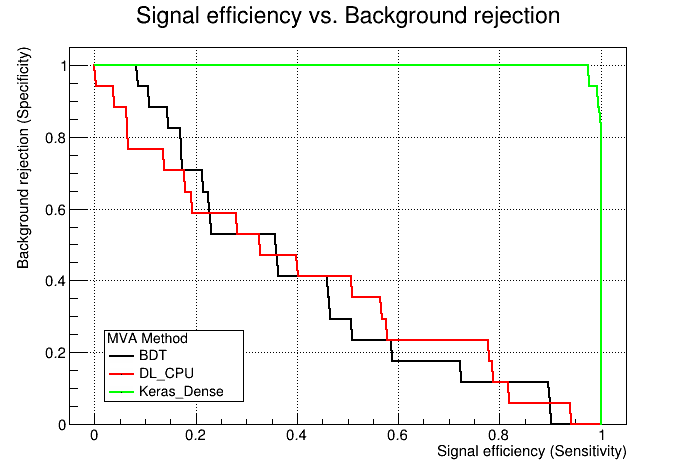

In [15]:
c1 = factory.GetROCCurve(loader)
c1.Draw()

As we increase layers amount in scikit-learn DL method, its performance gets worst. In parallel, BDT shows improvement when increasing the amount of trees, but it can't reach the performance of Keras, which gets better each time we increase the layers amount. In this case Keras it's almost ideal.

In [16]:
outputFile.Close()